# Grid QC'd Files Using Nearest Neighbor Interpolation

## Imports

In [1]:
import pyart
import matplotlib.pyplot as plt
import numpy as np
import glob
from pathlib import Path


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



ERROR 1: PROJ: proj_create_from_database: Open of /ccsopen/home/mgrover/mgrover/sail-radar-dev/share/proj failed


## Retrieve List of Files (QC'd Data)

In [2]:
files = sorted(glob.glob("/gpfs/wolf/atm124/proj-shared/gucxprecipradarcmacM1.c1/ppi/202203/gucxprecipradarcmacM1.c1.20220314-03*"))

## Load Data into Py-ART and Plot

In [3]:
radar = pyart.io.read(files[0])

(-20.0, 20.0)

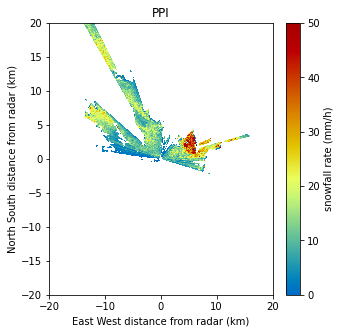

In [4]:
display = pyart.graph.RadarDisplay(radar)
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(111)
display.plot('snow_rate_ws88diw',
             0,
             vmin=0,
             vmax=50,
             title="PPI",
             cmap='pyart_HomeyerRainbow')
plt.xlim(-20, 20)
plt.ylim(-20, 20)

## Grid Using Nearest Neighbor Interpolation

### Setup a Helper Function and Configure our Grid

In [5]:
def compute_number_of_points(extent, resolution):
    """
    Create a helper function to determine number of points
    """
    return int((extent[1] - extent[0])/resolution)

# Grid extents in meters
z_grid_limits = (500.,5_000.)
y_grid_limits = (-20_000.,20_000.)
x_grid_limits = (-20_000.,20_000.)

# Grid resolution in meters
grid_resolution = 250

Once we setup our interpolation, we can compute the number of points for each extent

In [6]:
x_grid_points = compute_number_of_points(x_grid_limits, grid_resolution)
y_grid_points = compute_number_of_points(y_grid_limits, grid_resolution)
z_grid_points = compute_number_of_points(z_grid_limits, grid_resolution)

print(z_grid_points,
      y_grid_points,
      x_grid_points)

18 160 160


### Create our Grid using `grid_from_radars`

In [7]:
grid = pyart.map.grid_from_radars(radar,
                                  grid_shape=(z_grid_points,
                                              y_grid_points,
                                              x_grid_points),
                                  grid_limits=(z_grid_limits,
                                               y_grid_limits,
                                               x_grid_limits),
                                  method='nearest'
                                 )

## Visualize our Grid
We start by converting our grid to xarray

In [234]:
ds = grid.to_xarray()

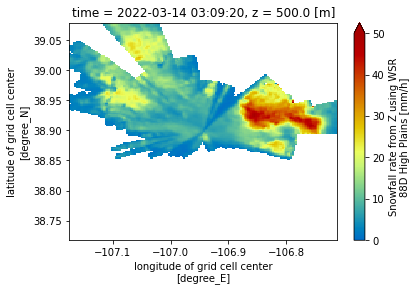

In [235]:
ds.snow_rate_ws88diw.isel(z=0).plot(x='lon',
                                    y='lat',
                                    vmin=0, 
                                    vmax=50,
                                    cmap='pyart_HomeyerRainbow')

## Determine the Lowest Height in Each Column
We plotted the lowest level (500 m) in the plot above. It would be **more helpful** to have data from the lowest data point (lowest z) in each column (across time, latitude, and longitude)

We start first by creating a new field in our dataset, `height_expanded`, which is a four-dimensional (time, z, x, y) vertical coordinate, with nan values where we have missing snow rate values.

In [211]:
ds["height_expanded"] = (ds.z * (ds.snow_rate_ws2012/ds.snow_rate_ws2012)).fillna(10_000)

Next, we find the index of the lowest value in this column, using the `.argmin` method, looking over the column (z)

In [216]:
min_index = ds.height_expanded.argmin(dim='z',
                                      skipna=True)

Here is a plot of the lowest value height in the column for our domain:

**Notice how some values are the top of the column - 5000 m, whereas some of the values are close lowest vertical level, 500 m

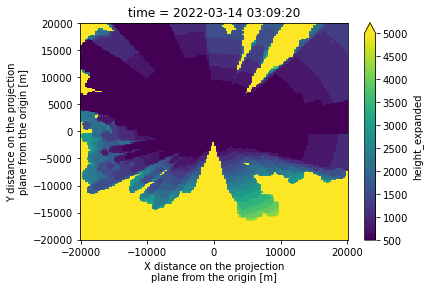

In [217]:
ds.height_expanded.isel(z=min_index).plot(vmin=500,
                                          vmax=5000);

### Apply this to our snow fields
We first check for snow fields in our dataset, by using the following list comprehension line:

In [227]:
snow_fields = [var for var in list(ds.variables) if "snow" in var]
snow_fields

['snow_rate_ws88diw',
 'snow_rate_m2009_1',
 'snow_rate_m2009_2',
 'snow_rate_ws2012']

Next, we subset our dataset for only these fields and select our lowest z value (using the index we built before)

In [195]:
subset_ds = ds[snow_fields].isel(z=min_index)

### Visualize our closest-to-ground snow value
Now that we have the lowest vertical level in each column, let's plot our revised maps, which only have dimensions:
- time
- latitude
- longitude

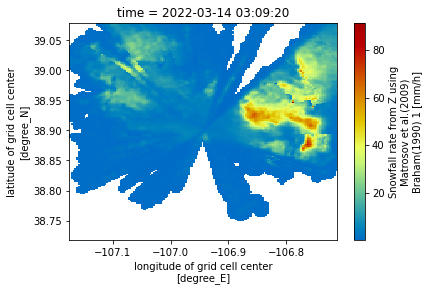

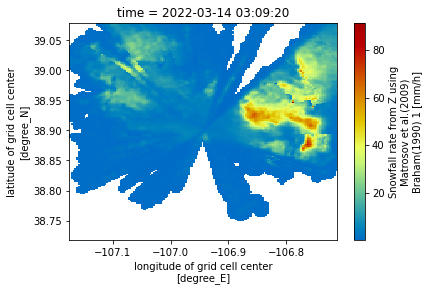

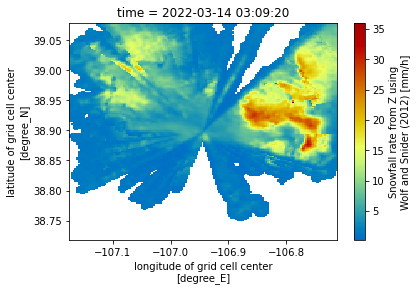

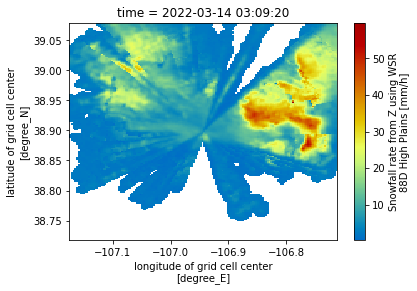

In [205]:
for snow_field in snow_fields:
    subset_ds[snow_field].plot(x='lon',
                               y='lat',
                               cmap='pyart_HomeyerRainbow')
    plt.show()
    plt.close()

## Wrap this Up into a Function
Now that we have the full pipeline, let's wrap this into a function!

In [12]:
def grid_radar(file,
               x_grid_limits=(-20_000.,20_000.),
               y_grid_limits=(-20_000.,20_000.),
               z_grid_limits = (500.,5_000.),
               grid_resolution = 250,
               
               ):
    """
    Grid the radar using some provided parameters
    """
    
    radar = pyart.io.read(file)
    
    x_grid_points = compute_number_of_points(x_grid_limits, grid_resolution)
    y_grid_points = compute_number_of_points(y_grid_limits, grid_resolution)
    z_grid_points = compute_number_of_points(z_grid_limits, grid_resolution)
    
    grid = pyart.map.grid_from_radars(radar,
                                      grid_shape=(z_grid_points,
                                                  y_grid_points,
                                                  x_grid_points),
                                      grid_limits=(z_grid_limits,
                                                   y_grid_limits,
                                                   x_grid_limits),
                                      method='nearest'
                                     )
    return grid.to_xarray()

def subset_lowest_vertical_level(ds, additional_fields=["corrected_reflectivity"]):
    """
    Filter the dataset based on the lowest vertical level
    """
    snow_fields = [var for var in list(ds.variables) if "snow" in var] + additional_fields
    
    # Create a new 4-d height field
    ds["height_expanded"] = (ds.z * (ds[snow_fields[0]]/ds[snow_fields[0]])).fillna(5_000)
    
    # Find the minimum height index
    min_index = ds.height_expanded.argmin(dim='z',
                                          skipna=True)
    
    # Subset our snow fields based on this new index
    subset_ds = ds[snow_fields].isel(z=min_index)
    
    return subset_ds

## Loop Through and Apply this Workflow
Now that we have our helper functions, we can apply our workflow to each file.

In [14]:
for file in files:
    ds = grid_radar(file)
    out_ds = subset_lowest_vertical_level(ds)
    
    # Create an output path
    out_path = f"gridded-for-dan/{Path(file).stem}.gridded.nc"
    out_ds.to_netcdf(out_path)
    print("Finished writing:", out_path)

Finished writing: gridded-for-dan/gucxprecipradarcmacM1.c1.20220314-030920.gridded.nc
Finished writing: gridded-for-dan/gucxprecipradarcmacM1.c1.20220314-032520.gridded.nc
Finished writing: gridded-for-dan/gucxprecipradarcmacM1.c1.20220314-033040.gridded.nc
Finished writing: gridded-for-dan/gucxprecipradarcmacM1.c1.20220314-033600.gridded.nc
Finished writing: gridded-for-dan/gucxprecipradarcmacM1.c1.20220314-034120.gridded.nc
Finished writing: gridded-for-dan/gucxprecipradarcmacM1.c1.20220314-034640.gridded.nc
Finished writing: gridded-for-dan/gucxprecipradarcmacM1.c1.20220314-035720.gridded.nc
